<a href="https://colab.research.google.com/github/bismilyah/123/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Third_Cap_project_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EDA Анализ эмоционального состояния через текстовые транскрипции разговоров.**

Техническое задание 1)	Анализ эмоциональной окраски текста (радость, грусть, гнев и др.).

In [1]:
pip install gensim

In [2]:
!pip install datasets
!pip install pandas pyarrow
!pip install fastparquet
!pip install duckdb

In [3]:
from huggingface_hub import snapshot_download

REPO_ID = "mteb/tweet_sentiment_extraction"  # replace with actual dataset repo ID

local_dir = snapshot_download(repo_id=REPO_ID, repo_type="dataset")
print(f"Dataset downloaded to: {local_dir}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

Dataset downloaded to: /root/.cache/huggingface/hub/datasets--mteb--tweet_sentiment_extraction/snapshots/3703f2e1b6b0ce0a08de382f7d4eb2625cc22cf9


In [4]:
import duckdb
# Преобразование Датасета в формат CSV
duckdb.sql("""
    COPY (SELECT * FROM '/content/train-00000-of-00001 (5).parquet')
    TO 'train_file.csv' (HEADER, FORMAT 'csv')
""")

In [5]:
import pandas as pd
# Загрузка Датасета в файте CSV
df = pd.read_csv('train_file.csv')
df.head()

,text,label
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


In [6]:
# Пример текста, строка 1234
df.text[1234]

'Going to jog down to uni. Quite a way from my family home but exercise and all that'

In [7]:
# Типы коллон в таблице
df.columns.value_counts()

,count
text,1
label,1


In [9]:
# Объем датасета
df.shape

(27481, 2)

In [10]:
total_missing = df.isnull().sum().sum()
print("Всего пропущенных значений:", total_missing)

Всего пропущенных значений: 1


In [11]:
# Удаление строки
df_dropped_rows = df.dropna()
print(df_dropped_rows.shape)
# Преобразование столбца 'label' в числовой, удаление недопустимых строк
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df = df.dropna(subset=['label'])

(27480, 2)


In [13]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess(text):
    if not isinstance(text, str):
        return ""
     # Приведение к нижнему регистру
    text = text.lower()
    # Удаление пунктуации
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Токенизация
    tokens = word_tokenize(text)
    # Удаление стоп-слов, лемматизация и стемминг
    cleaned_tokens = [lemmatizer.lemmatize(stemmer.stem(token)) for token in tokens if token not in stop_words]
    tokens = cleaned_tokens
    return " ".join(tokens)
df['Clean_text'] = df['text'].apply(preprocess)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,label,Clean_text
0,"I`d have responded, if I were going",1,id respond go
1,Sooo SAD I will miss you here in San Diego!!!,0,sooo sad miss san diego
2,my boss is bullying me...,0,bos bulli
3,what interview! leave me alone,0,interview leav alon
4,"Sons of ****, why couldn`t they put them on t...",0,son couldnt put releas alreadi bought


**Анализ** **длинны** **текстов**

In [50]:
#  Расчёт длины ответов
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['text'].apply(lambda x: len(str(x)))

Гистограммы распределения

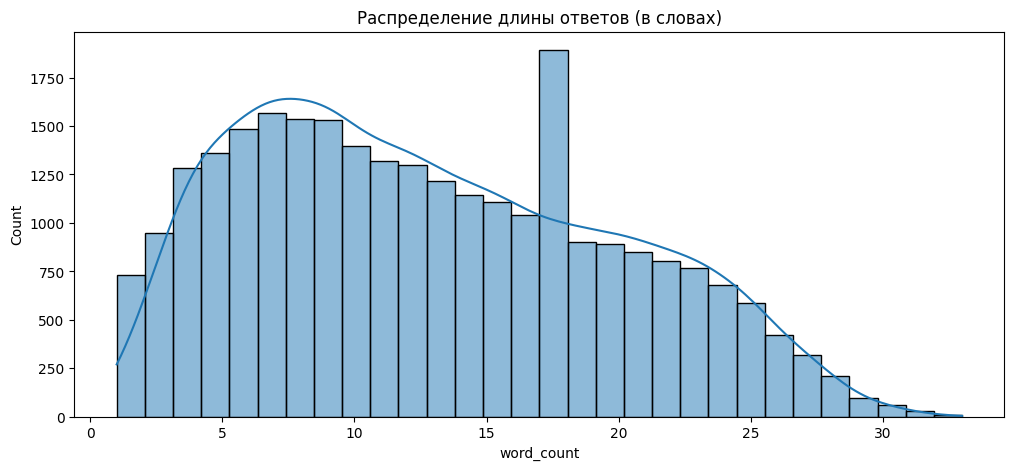

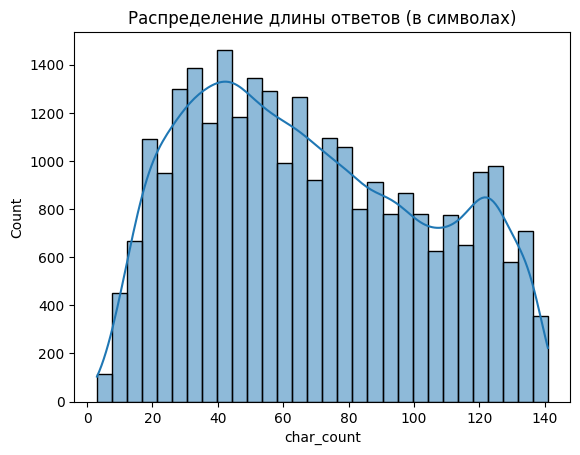

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))
sns.histplot(df['word_count'], bins=30, kde=True)
plt.title('Распределение длины ответов (в словах)')
plt.show()

sns.histplot(df['char_count'], bins=30, kde=True)
plt.title('Распределение длины ответов (в символах)')
plt.show()

In [52]:
# Поиск выбросов
print(df['word_count'].describe())
print(df['char_count'].describe())
# Можно выделить ответы <5 и >95 перцентиля как выбросы

count    27481.000000
mean        12.902442
std          6.926185
min          1.000000
25%          7.000000
50%         12.000000
75%         18.000000
max         33.000000
Name: word_count, dtype: float64
count    27481.000000
mean        68.327645
std         35.605403
min          3.000000
25%         39.000000
50%         64.000000
75%         97.000000
max        141.000000
Name: char_count, dtype: float64


**Лексический** **анализ**

In [55]:
def clean_and_tokenize(text):
    tokens = nltk.word_tokenize(str(text).lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return tokens
df['tokens'] = df['text'].apply(clean_and_tokenize)

# Частотность
from collections import Counter
all_words = [word for tokens in df['tokens'] for word in tokens]
word_freq = Counter(all_words)
print(word_freq.most_common(20))

[('day', 2084), ('good', 1569), ('get', 1428), ('like', 1348), ('go', 1274), ('got', 1245), ('http', 1243), ('work', 1143), ('today', 1141), ('love', 1139), ('going', 1099), ('lol', 1013), ('happy', 993), ('one', 990), ('time', 957), ('u', 944), ('know', 939), ('really', 914), ('back', 902), ('im', 850)]


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X = df['Clean_text']
y = df['label']

# Преобразование данных в tf-idf
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Обучение модели
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6159723485537566
              precision    recall  f1-score   support

           0       0.77      0.39      0.52      1562
           1       0.53      0.83      0.65      2230
           2       0.76      0.55      0.63      1705

    accuracy                           0.62      5497
   macro avg       0.69      0.59      0.60      5497
weighted avg       0.67      0.62      0.61      5497



In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

model_name = "seara/rubert-base-cased-ru-go-emotions"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Если есть GPU, используем его
device = 0 if torch.cuda.is_available() else -1

# Создаём pipeline для удобства
emotion_classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=device,
    top_k=None,
    return_all_scores=True  # возвращать вероятности для всех эмоций
)

Device set to use cpu


In [27]:
# Функция для получения эмоций с вероятностями
def get_emotions(text):
    results = emotion_classifier(text)
    # results — список словарей с label и score для каждой эмоции
    return {item['label']: item['score'] for item in results[0]}

# Пример для одного текста
example_text = df.loc[0, 'clean_text'] if 'clean_text' in df.columns else df.loc[0, 'text']
emotions = get_emotions(example_text)
print(f"Текст: {example_text}")
print("Эмоции и вероятности:", emotions)

Текст:  I`d have responded, if I were going
Эмоции и вероятности: {'neutral': 0.5673993825912476, 'optimism': 0.2635394334793091, 'approval': 0.09032496064901352, 'desire': 0.03877442330121994, 'caring': 0.02936360239982605, 'realization': 0.02014607936143875, 'curiosity': 0.020080959424376488, 'annoyance': 0.010786658152937889, 'admiration': 0.010648728348314762, 'confusion': 0.009628686122596264, 'disapproval': 0.009176825173199177, 'disappointment': 0.008641897700726986, 'excitement': 0.008575113490223885, 'surprise': 0.005598622839897871, 'anger': 0.0033267319668084383, 'joy': 0.0029949466697871685, 'amusement': 0.002899611135944724, 'gratitude': 0.0027427792083472013, 'relief': 0.002142281737178564, 'sadness': 0.0019200533861294389, 'love': 0.0018547429936006665, 'disgust': 0.001815740717574954, 'fear': 0.001803344115614891, 'nervousness': 0.001459576771594584, 'pride': 0.0013946054968982935, 'grief': 0.0009626605897210538, 'embarrassment': 0.0008481881814077497, 'remorse': 0.0007

In [28]:
# Применяем к каждому тексту и сохраняем результат в новую колонку
df['emotions'] = df['Clean_text'].apply(get_emotions)

# Посмотрим на результат
df[['Clean_text', 'emotions']].head()

,Clean_text,emotions
0,id respond go,"{'neutral': 0.9174204468727112, 'approval': 0...."
1,sooo sad miss san diego,"{'sadness': 0.7838623523712158, 'disappointmen..."
2,bos bulli,"{'neutral': 0.9253687858581543, 'annoyance': 0..."
3,interview leav alon,"{'neutral': 0.8882163166999817, 'approval': 0...."
4,son couldnt put releas alreadi bought,"{'neutral': 0.8555911183357239, 'approval': 0...."


In [44]:
def classify_emotion(text):
    # Получаем список словарей с эмоциями и их вероятностями
    results = classifier(text, return_all_scores=True)
    # Берём первый (и единственный) элемент, если text — строка
    scores = results[0] if isinstance(text, str) else results

    # Находим эмоцию с максимальным score
    best = max(scores, key=lambda x: x['score'])
    label = best['label'].lower()
    score = best['score']
    return label, score

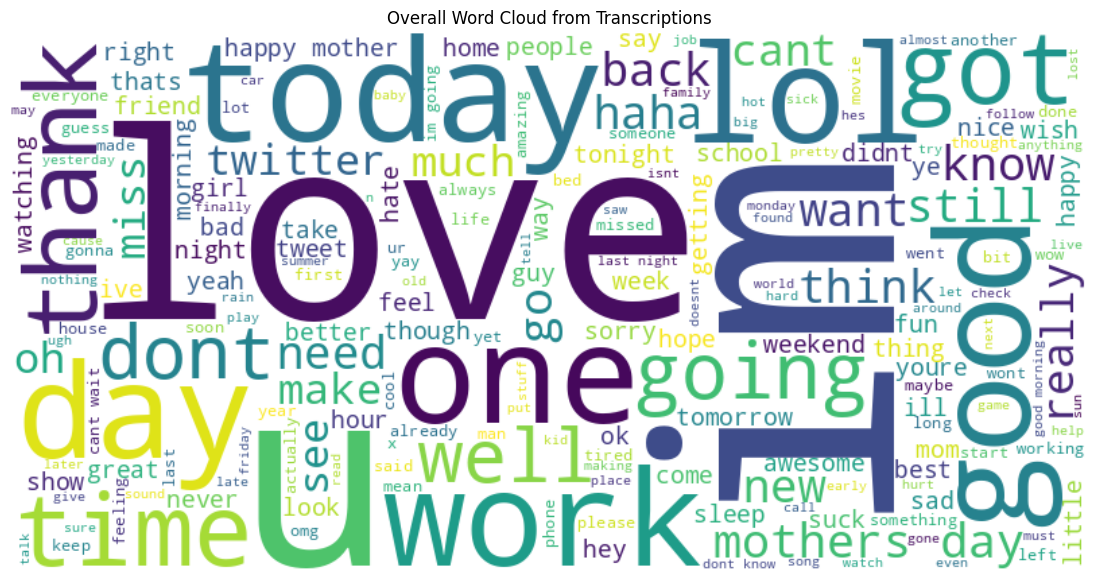

In [22]:
# 7. Visualization - Word Cloud of most frequent words overall
all_text = " ".join(df['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Overall Word Cloud from Transcriptions")
plt.show()


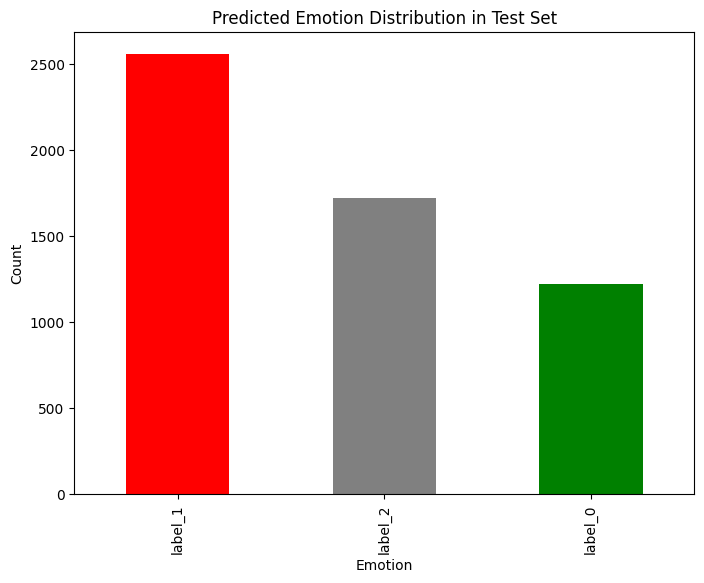

In [23]:
# 8. Visualization - Emotion distribution in test set
emotion_counts = test_df['predicted_emotion'].value_counts()
plt.figure(figsize=(8,6))
emotion_counts.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title("Predicted Emotion Distribution in Test Set")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

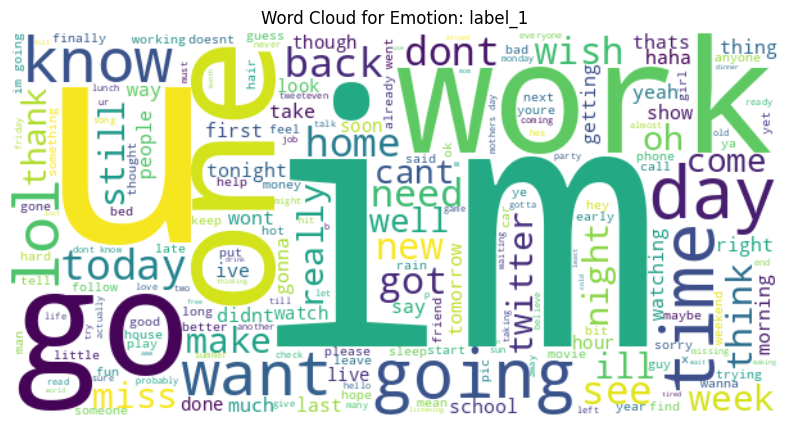

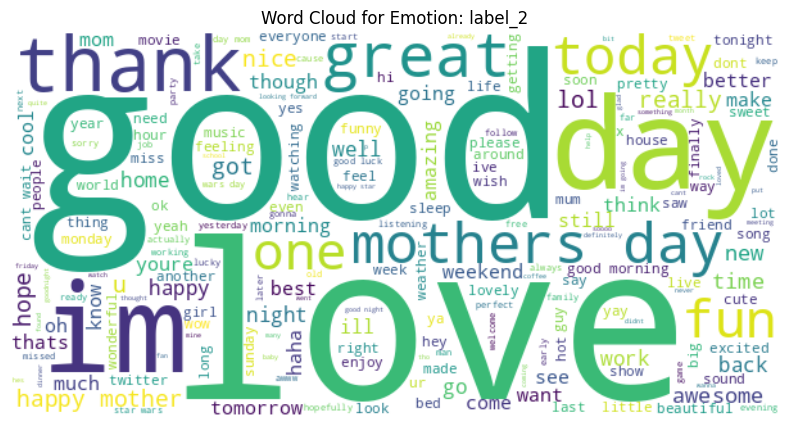

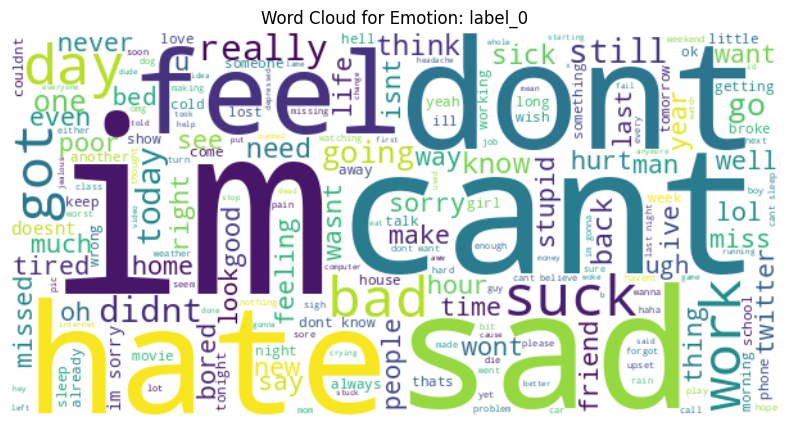

In [24]:
# 9. Example: Visualize word clouds per predicted emotion
for emotion in emotion_counts.index:
    text = " ".join(test_df[test_df['predicted_emotion'] == emotion]['clean_text'])
    wc = WordCloud(width=600, height=300, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Emotion: {emotion}")
    plt.show()